Настройка и подготовка среды

In [40]:
import random
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#Для подбора параметров модели
from scipy.optimize import curve_fit

#Настройки вывода (построения) графиков
%matplotlib inline
plt.style.use('seaborn-whitegrid')

Импорт датафрейма

In [41]:
input_frame = pd.read_csv("portfolio_data.csv")
input_frame

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...,...
1515,5/8/2019,1917.770020,283.149994,6171.959961,364.369995
1516,5/9/2019,1899.869995,282.160004,6358.290039,362.750000
1517,5/10/2019,1889.979980,278.369995,7191.359863,361.040009
1518,5/13/2019,1822.680054,273.880005,7980.129883,345.260010


Разбиение датасета на тренировочный и тестовый (70/30). Вывод тренировочного сета

In [42]:
size = len(input_frame)
train_size_multiplier = 0.8
train_size = int(size * train_size_multiplier)

train = input_frame.iloc[:train_size] 
test = input_frame.iloc[train_size:]

train

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...,...
1211,2/21/2018,1482.920044,227.955032,10481.660160,281.040009
1212,2/22/2018,1485.339966,224.464478,9847.959961,278.140015
1213,2/23/2018,1500.000000,226.293793,10175.509770,285.929993
1214,2/26/2018,1521.949951,225.473083,10326.500000,294.160004


Разбиение тренировочного сета по компаниям. Построение графика стоимости акций компаний. 

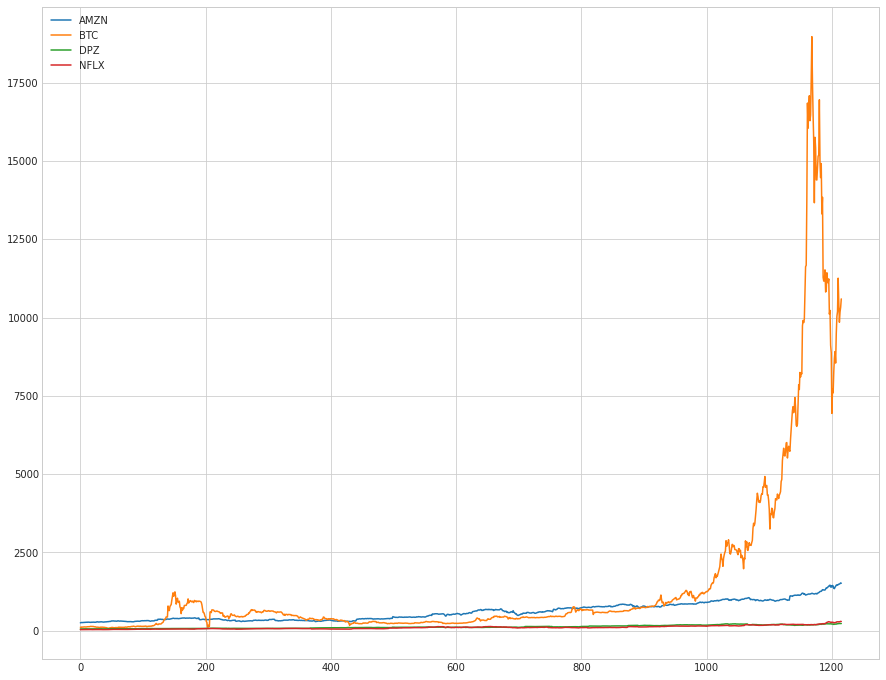

In [43]:
dates = pd.DataFrame(train['Date'], train.index)
amzn = pd.DataFrame(train['AMZN'], train.index)
dpz = pd.DataFrame(train['DPZ'], train.index)
btc = pd.DataFrame(train['BTC'], train.index)
nflx = pd.DataFrame(train['NFLX'], train.index)

plt.figure(figsize=(15, 12))
plt.plot(amzn, label='AMZN')
plt.plot(btc, label='BTC')
plt.plot(dpz, label='DPZ')
plt.plot(nflx, label='NFLX')
plt.legend(); 

Вывод характеристик данных стоимости различных компаний из тренировочного сета. 

In [44]:
train.describe()

,AMZN,DPZ,BTC,NFLX
count,1216.000000,1216.000000,1216.000000,1216.000000
mean,600.592204,118.217057,1497.352800,99.970480
std,292.773934,48.320868,2928.733921,52.553209
min,248.229996,51.190983,69.660004,29.464285
25%,334.492501,71.632040,273.974991,58.082144
50%,532.729981,105.989105,478.330001,94.354999
75%,807.812516,162.477245,920.912490,125.664997
max,1521.949951,227.955032,18972.320310,294.160004


Выделение тренда в данных (удаление шумов). На примере стоимости акций компании AMZN. 

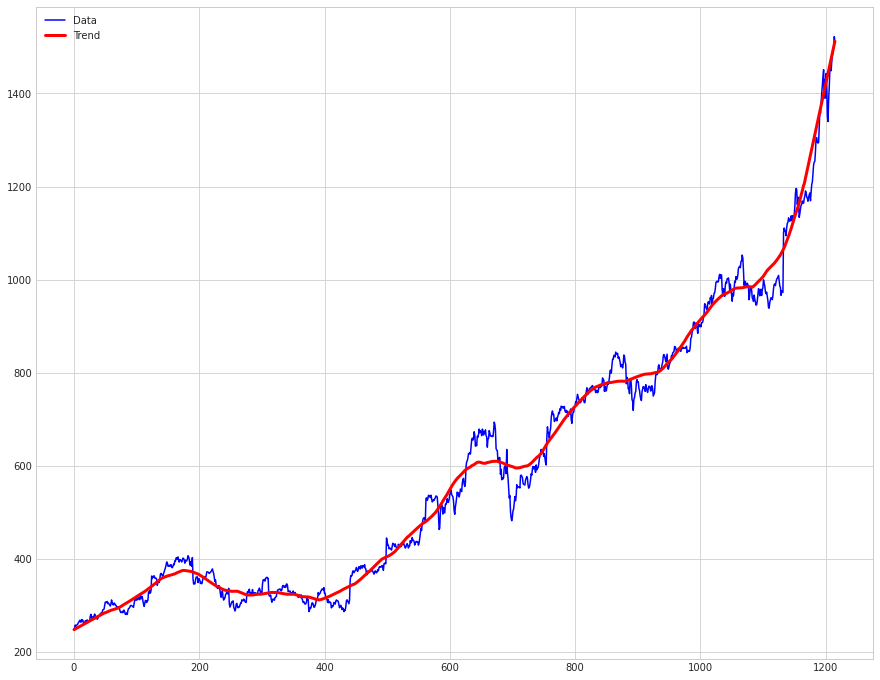

In [45]:
def calc_trend(data, win_size = 100):
    left = list(np.linspace(data[0], data[:win_size].mean(), win_size // 2)) #linear aproximation
    middle = list(float(data[i - win_size // 2:i + win_size // 2].mean()) for i in range(win_size // 2, len(data) - win_size // 2)) #mean window aproximation
    right = list(np.linspace(data[len(data)-win_size-1:].mean(), data[len(data)-1], win_size // 2))
    return left + middle + right

trend_data = amzn
new_trend = calc_trend(trend_data.iloc[:, 0], win_size=100)
plt.figure(figsize=(15, 12))
plt.plot(trend_data, label='Data', color='b')
plt.plot(new_trend, label='Trend', color='r', linewidth=3)
plt.legend()

Методы для удобного получения коэффициента корреляции и параметров модели в легко читаемом виде. 

In [46]:
def corrcoef(x, y):
    print(f'{getcorrcoef(x, y):.5f}')

def getcorrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]


def pretty_params(a_, c_, popt_):
    pretty_c = 'None' if c_ is None else f'{c_:.5f}'

    print(f'a={a_:.5f}; b={popt_[0]:.5f}; c={pretty_c}; d={popt_[2]:.5f}; e={popt_[3]:.5f}; f={popt_[4]:.5f};')

Подготовка моделей. Определение функций. Без рандоим - для подбора параметров. С рандомом - для итоговой модели.

In [47]:
#Фиксируем сид рандома. Для воспроизводимости экспериментов.
random.seed(100)
def func(x, b, c, d, e, f):
    return e * x * np.exp(b * x) + f * np.sin(x * d)

def func_with_noise(x, b, c, d, e, f, c2):
    return e * x * np.exp(b * x) + f * np.sin(x * d) * (np.random.random(len(x)) * c2)

Подбор параметров для оптимизированной функции модели. На примере акций Амазона.

Params values
a=248.23000; b=2.58777; c=None; d=1.69199; e=145.32740; f=163.38877;
Correlation coeff
0.98612


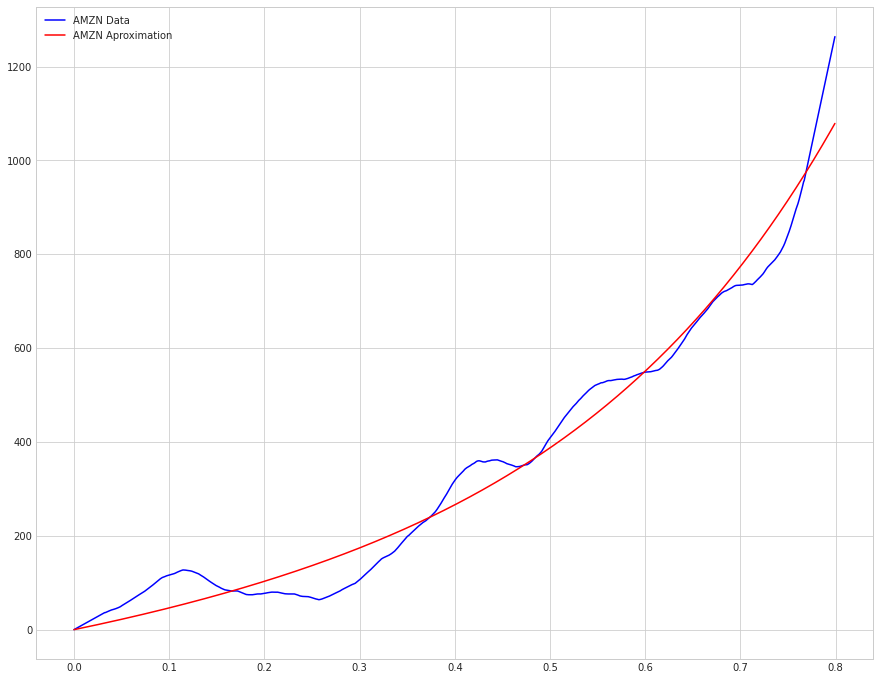

In [48]:
data_for_input = amzn
name = 'AMZN'

trend = calc_trend(data_for_input.iloc[:, 0])
a = trend[0]
ydata = np.asarray(trend) - a 
xdata = np.asarray(list(range(0, len(ydata)))) / len(input_frame)
popt, pcov = curve_fit(func, xdata, ydata, method='trf')

plt.figure(figsize=(15, 12))
plt.plot(xdata, ydata, color='blue', label=f'{name} Data')
y_aprox_data = func(xdata, *popt)
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.legend()

print("Params values")
pretty_params(a, None, popt)
print("Correlation coeff")
trend_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=248.23000; b=2.58777; c=1.60000; d=1.69199; e=145.32740; f=163.38877;
Correlation coeff
0.96350


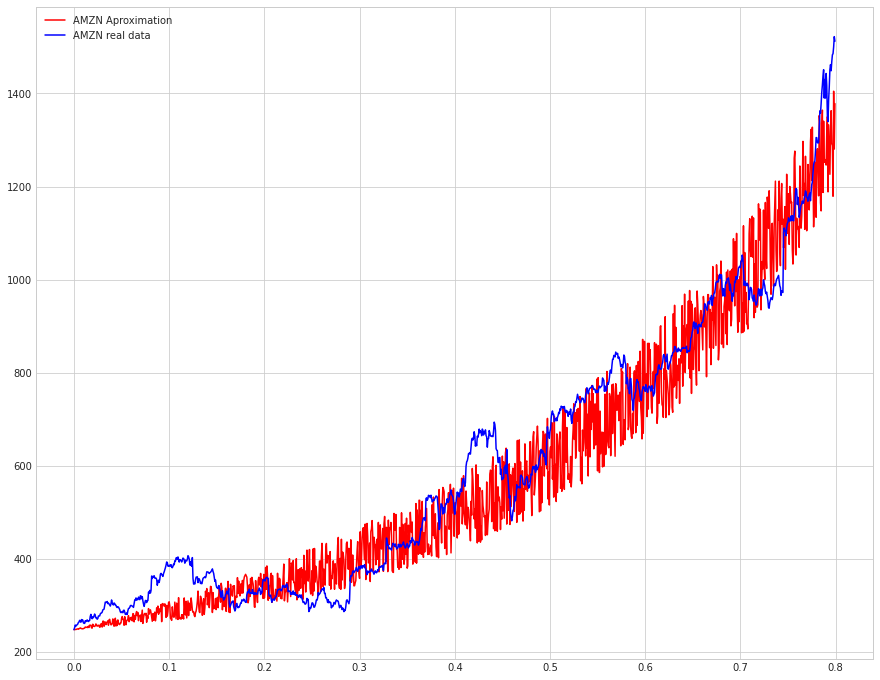

In [49]:
c = 1.6
ydata = data_for_input.iloc[:, 0]
plt.figure(figsize=(15, 12))
y_aprox_data = func_with_noise(xdata, *popt, c) + a
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(xdata, ydata, color='blue', label=f'{name} real data')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
noise_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=248.23000; b=2.58777; c=1.60000; d=1.69199; e=145.32740; f=163.38877;
Correlation coeff
0.96204


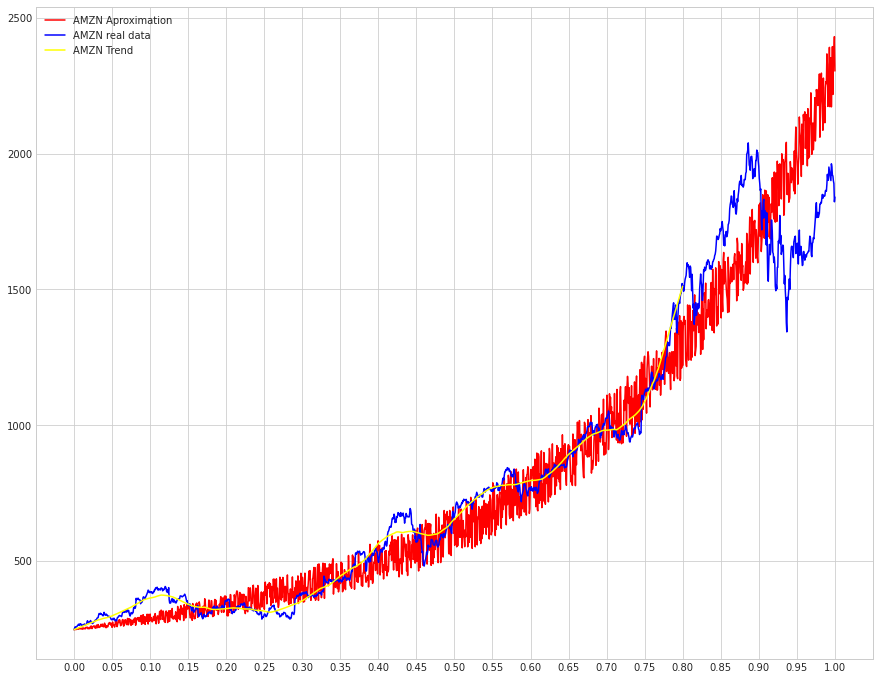

In [50]:
x_for_test = np.asarray(np.linspace(0, 1, len(input_frame)))
ydata = input_frame[name]
y_aprox_data = func_with_noise(x_for_test, *popt, c) + a
plt.figure(figsize=(15, 12))
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
plt.plot(x_for_test, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(x_for_test, ydata, color='blue', label=f'{name} real data')
plt.plot(x_for_test[:len(trend)], trend, color='yellow', label=f'{name} Trend')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
real_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

In [51]:
print(f'Параметры модели для стоимости акций {name}')
pretty_params(a, c, popt)
print('Correlation coeff:')
print(f'Corr coef with trend:     {trend_corrcoef:.5f}')
print(f'Corr coef with noise:     {noise_corrcoef:.5f}')
print(f'Final (real) corr coef:   {real_corrcoef:.5f}')

Параметры модели для стоимости акций AMZN
a=248.23000; b=2.58777; c=1.60000; d=1.69199; e=145.32740; f=163.38877;
Correlation coeff:
Corr coef with trend:     0.98612
Corr coef with noise:     0.96350
Final (real) corr coef:   0.96204


Моделирование стоимости ценных бумаг для компании BTC. 

Params values
a=106.25000; b=10.71289; c=None; d=7.19778; e=3.11886; f=419.15801;
Correlation coeff
0.98537


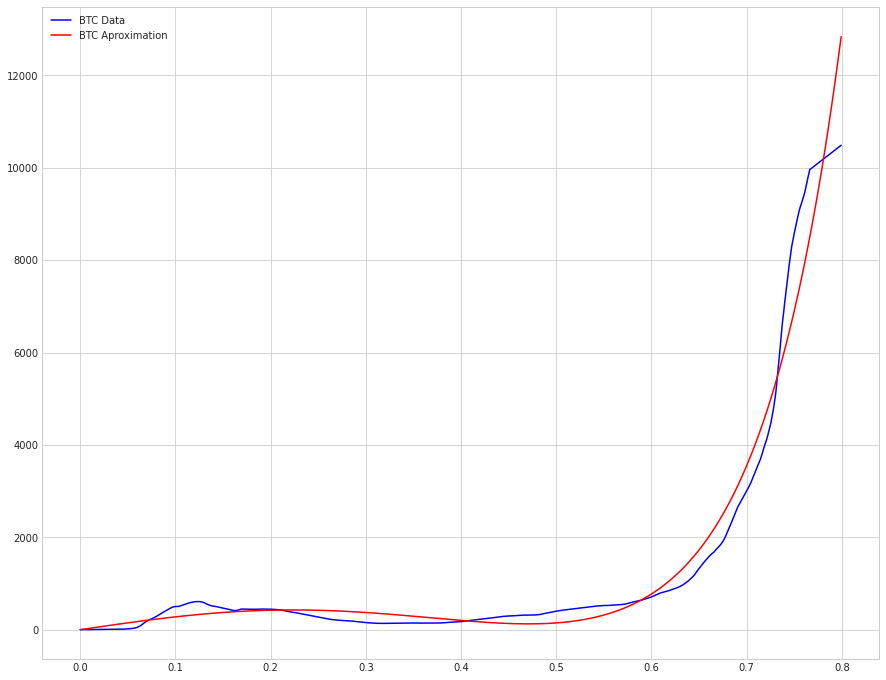

In [52]:
data_for_input = btc
name = 'BTC'

trend = calc_trend(data_for_input.iloc[:, 0])
a = trend[0]
ydata = np.asarray(trend) - a 
xdata = np.asarray(list(range(0, len(ydata)))) / len(input_frame)
popt, pcov = curve_fit(func, xdata, ydata, method='trf')

plt.figure(figsize=(15, 12))
plt.plot(xdata, ydata, color='blue', label=f'{name} Data')
y_aprox_data = func(xdata, *popt)
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.legend()

print("Params values")
pretty_params(a, None, popt)
print("Correlation coeff")
trend_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=106.25000; b=10.71289; c=1.37000; d=7.19778; e=3.11886; f=419.15801;
Correlation coeff
0.92477


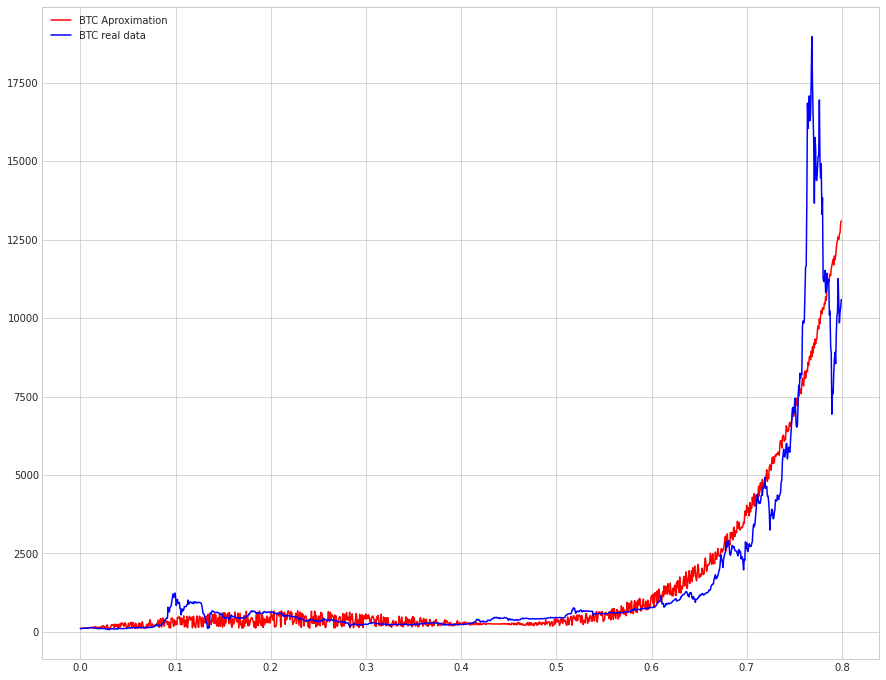

In [53]:
c = 1.37
ydata = data_for_input.iloc[:, 0]
plt.figure(figsize=(15, 12))
y_aprox_data = func_with_noise(xdata, *popt, c) + a
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(xdata, ydata, color='blue', label=f'{name} real data')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
noise_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=106.25000; b=10.71289; c=1.37000; d=7.19778; e=3.11886; f=419.15801;
Correlation coeff
0.40664


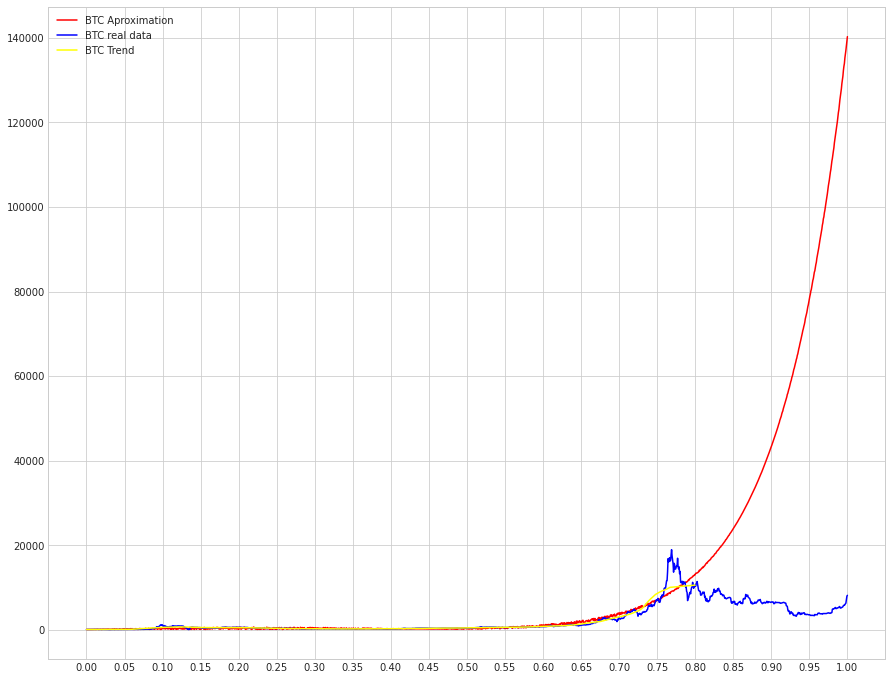

In [54]:
x_for_test = np.asarray(np.linspace(0, 1, len(input_frame)))
ydata = input_frame[name]
y_aprox_data = func_with_noise(x_for_test, *popt, c) + a
plt.figure(figsize=(15, 12))
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
plt.plot(x_for_test, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(x_for_test, ydata, color='blue', label=f'{name} real data')
plt.plot(x_for_test[:len(trend)], trend, color='yellow', label=f'{name} Trend')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
real_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

In [55]:
print(f'Параметры модели для стоимости акций {name}')
pretty_params(a, c, popt)
print('Correlation coeff:')
print(f'Corr coef with trend:     {trend_corrcoef:.5f}')
print(f'Corr coef with noise:     {noise_corrcoef:.5f}')
print(f'Final (real) corr coef:   {real_corrcoef:.5f}')

Параметры модели для стоимости акций BTC
a=106.25000; b=10.71289; c=1.37000; d=7.19778; e=3.11886; f=419.15801;
Correlation coeff:
Corr coef with trend:     0.98537
Corr coef with noise:     0.92477
Final (real) corr coef:   0.40664


Моделирование стоимости ценных бумаг для компании DPZ. 

Params values
a=51.19098; b=0.89254; c=None; d=17.19434; e=102.60744; f=-5.56481;
Correlation coeff
0.99255


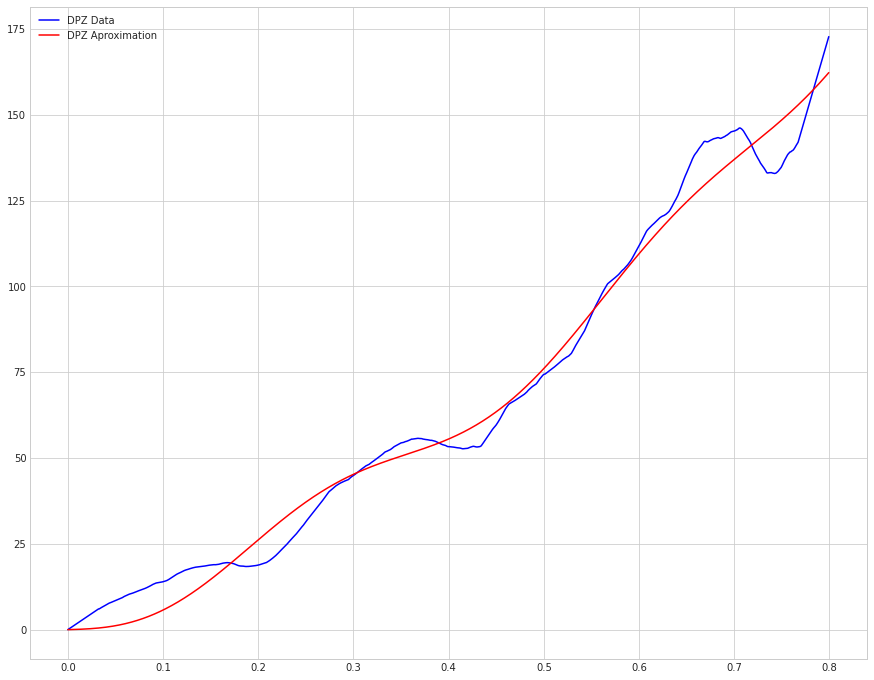

In [56]:
# data_for_input = input_frame['DPZ'].iloc[:int(size * 0.8)]
data_for_input = dpz
name = 'DPZ'

trend = calc_trend(data_for_input.iloc[:, 0])
a = trend[0]
ydata = np.asarray(trend) - a 
xdata = np.asarray(list(range(0, len(ydata)))) / len(input_frame)
popt, pcov = curve_fit(func, xdata, ydata, method='dogbox')

plt.figure(figsize=(15, 12))
plt.plot(xdata, ydata, color='blue', label=f'{name} Data')
y_aprox_data = func(xdata, *popt)
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.legend()

print("Params values")
pretty_params(a, None, popt)
print("Correlation coeff")
trend_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=51.19098; b=0.89254; c=3.00000; d=17.19434; e=102.60744; f=-5.56481;
Correlation coeff
0.97898


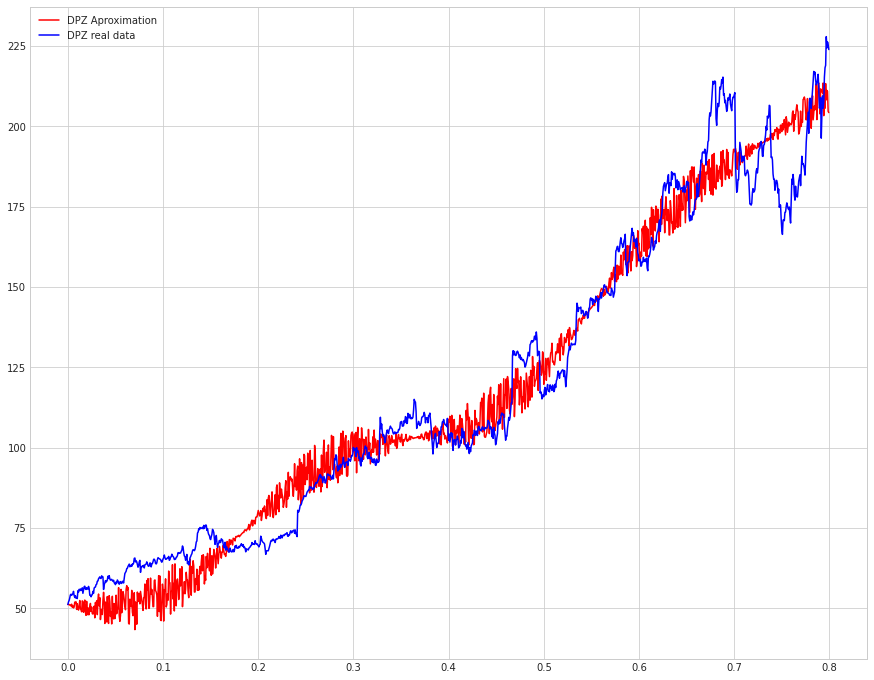

In [57]:
c = 3
ydata = data_for_input.iloc[:, 0]
plt.figure(figsize=(15, 12))
y_aprox_data = func_with_noise(xdata, *popt, c) + a
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(xdata, ydata, color='blue', label=f'{name} real data')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
noise_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=51.19098; b=0.89254; c=3.00000; d=17.19434; e=102.60744; f=-5.56481;
Correlation coeff
0.97342


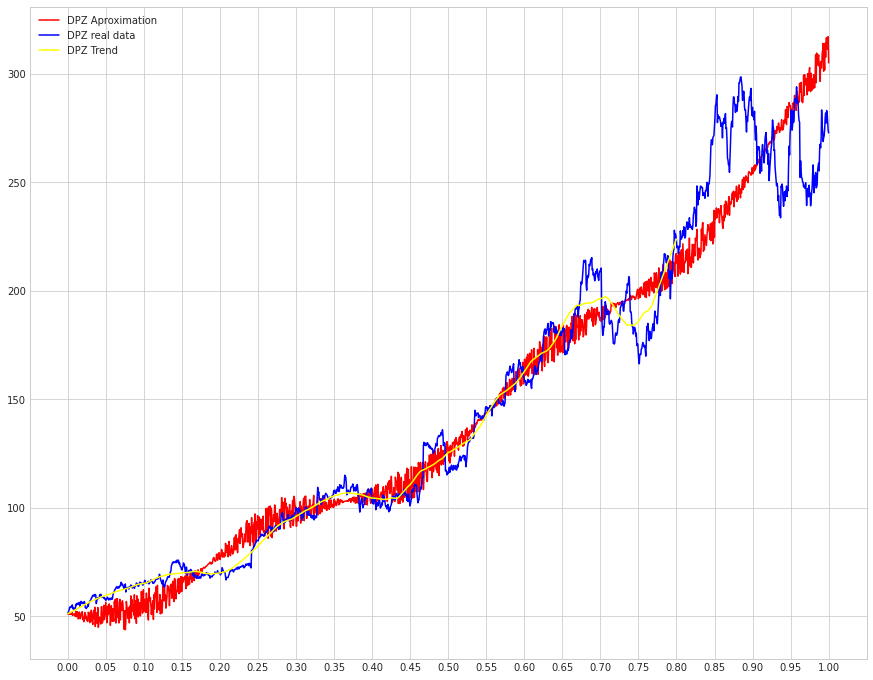

In [58]:
x_for_test = np.asarray(np.linspace(0, 1, len(input_frame)))
ydata = input_frame[name]
y_aprox_data = func_with_noise(x_for_test, *popt, c) + a
plt.figure(figsize=(15, 12))
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
plt.plot(x_for_test, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(x_for_test, ydata, color='blue', label=f'{name} real data')
plt.plot(x_for_test[:len(trend)], trend, color='yellow', label=f'{name} Trend')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
real_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

In [59]:
print(f'Параметры модели для стоимости акций {name}')
pretty_params(a, c, popt)
print('Correlation coeff:')
print(f'Corr coef with trend:     {trend_corrcoef:.5f}')
print(f'Corr coef with noise:     {noise_corrcoef:.5f}')
print(f'Final (real) corr coef:   {real_corrcoef:.5f}')

Параметры модели для стоимости акций DPZ
a=51.19098; b=0.89254; c=3.00000; d=17.19434; e=102.60744; f=-5.56481;
Correlation coeff:
Corr coef with trend:     0.99255
Corr coef with noise:     0.97898
Final (real) corr coef:   0.97342


Моделирование стоимости ценных бумаг для компании NFLX.

Params values
a=30.41571; b=12.48018; c=None; d=1.21745; e=0.00838; f=127.41417;
Correlation coeff
0.98478


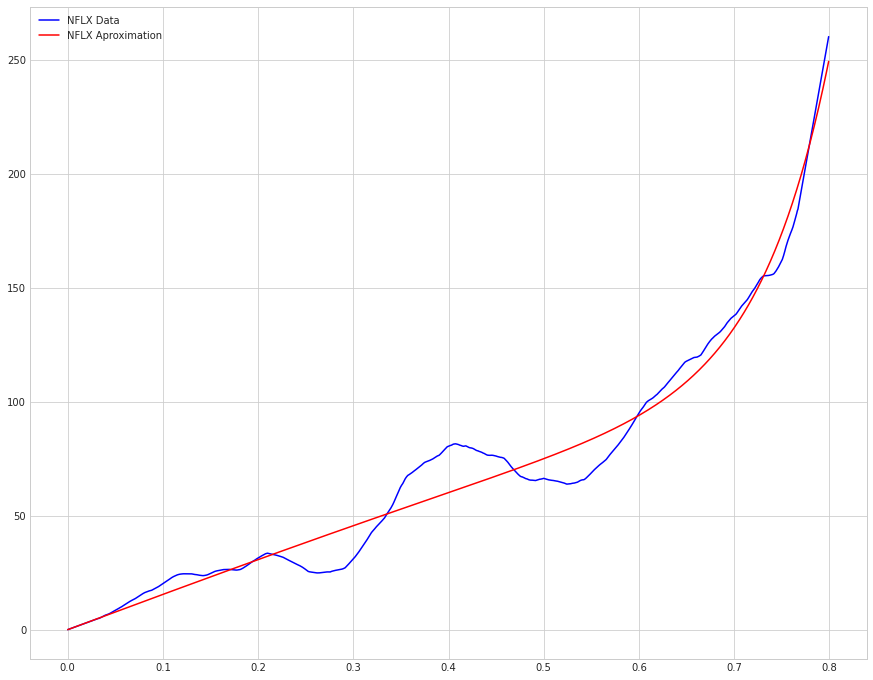

In [60]:
data_for_input = nflx
name = 'NFLX'

trend = calc_trend(data_for_input.iloc[:, 0])
a = trend[0]
ydata = np.asarray(trend) - a 
xdata = np.asarray(list(range(0, len(ydata)))) / len(input_frame)
popt, pcov = curve_fit(func, xdata, ydata, method='trf')

plt.figure(figsize=(15, 12))
plt.plot(xdata, ydata, color='blue', label=f'{name} Data')
y_aprox_data = func(xdata, *popt)
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.legend()

print("Params values")
pretty_params(a, None, popt)
print("Correlation coeff")
trend_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=60.41571; b=12.48018; c=0.75000; d=1.21745; e=0.00838; f=127.41417;
Correlation coeff
0.87173


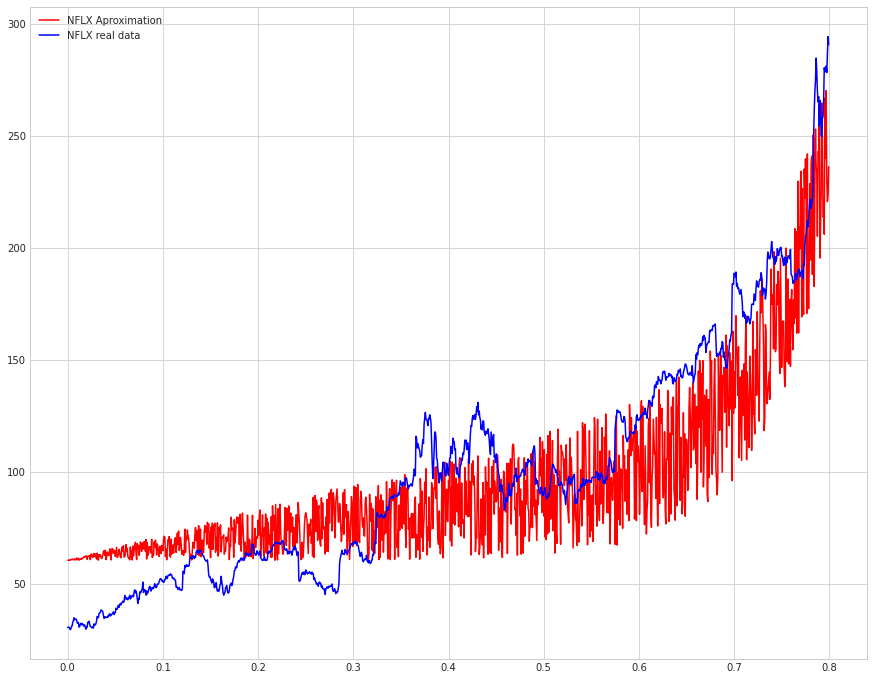

In [61]:
c = 0.75
a = trend[0] + 30
ydata = data_for_input.iloc[:, 0]
plt.figure(figsize=(15, 12))
y_aprox_data = func_with_noise(xdata, *popt, c) + a
plt.plot(xdata, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(xdata, ydata, color='blue', label=f'{name} real data')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
noise_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

Params values
a=60.41571; b=12.48018; c=0.75000; d=1.21745; e=0.00838; f=127.41417;
Correlation coeff
0.73088


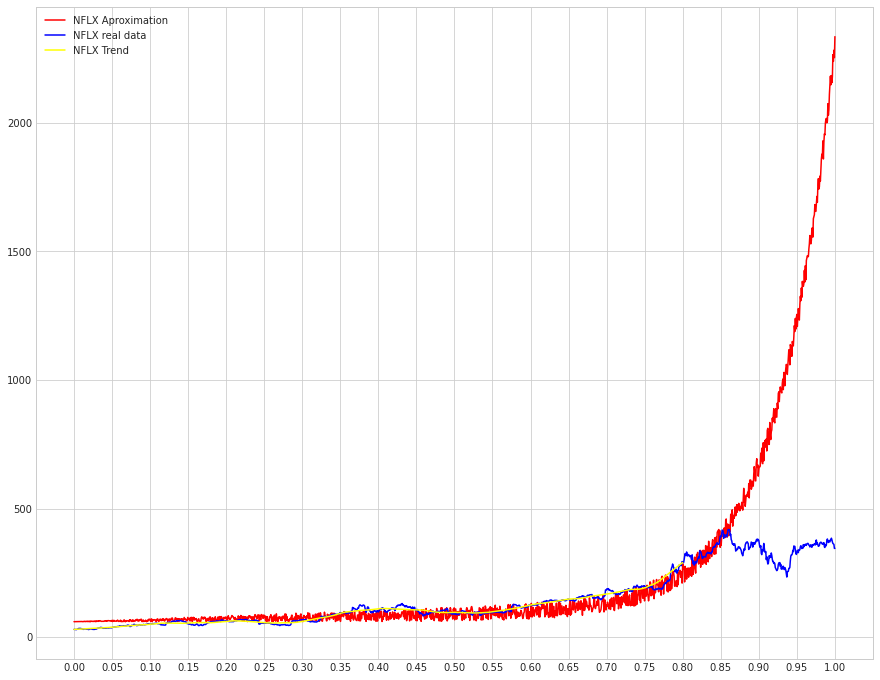

In [62]:
x_for_test = np.asarray(np.linspace(0, 1, len(input_frame)))
ydata = input_frame[name]
y_aprox_data = func_with_noise(x_for_test, *popt, c) + a
plt.figure(figsize=(15, 12))
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
plt.plot(x_for_test, y_aprox_data, color='red', label=f'{name} Aproximation')
plt.plot(x_for_test, ydata, color='blue', label=f'{name} real data')
plt.plot(x_for_test[:len(trend)], trend, color='yellow', label=f'{name} Trend')
plt.legend()

print("Params values")
pretty_params(a, c, popt)
print("Correlation coeff")
real_corrcoef = getcorrcoef(y_aprox_data, ydata)
corrcoef(y_aprox_data, ydata)

In [63]:
print(f'Параметры модели для стоимости акций {name}')
pretty_params(a, c, popt)
print('Correlation coeff:')
print(f'Corr coef with trend:     {trend_corrcoef:.5f}')
print(f'Corr coef with noise:     {noise_corrcoef:.5f}')
print(f'Final (real) corr coef:   {real_corrcoef:.5f}')

Параметры модели для стоимости акций NFLX
a=60.41571; b=12.48018; c=0.75000; d=1.21745; e=0.00838; f=127.41417;
Correlation coeff:
Corr coef with trend:     0.98478
Corr coef with noise:     0.87173
Final (real) corr coef:   0.73088


Часть с вычислением дат, для анализа эффективности аппроксимации

In [64]:
last_training_date = datetime.strptime(str(dates.iloc[-1, 0]), '%m/%d/%Y')
last_date = datetime.strptime(str(input_frame.iloc[-1, 0]), '%m/%d/%Y')
first_date = datetime.strptime(str(input_frame.iloc[0, 0]), '%m/%d/%Y')

print(f'Last training date: {last_training_date.date()}\nLast date: {last_date.date()}\nDifference: {last_date - last_training_date}')
print(f'Days in 0.05 parts: {(last_date - last_training_date) / 4}')

Last training date: 2018-02-27
Last date: 2019-05-14
Difference: 441 days, 0:00:00
Days in 0.05 parts: 110 days, 6:00:00
